In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

from sklearn.linear_model import LinearRegression

import pystan

import matplotlib.pyplot as plt

In [2]:
plt.style.context('seaborn')

In [3]:
df = pd.read_csv(
    'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv', 
    header=None, 
    parse_dates=[0], 
    dtype={1: np.float16}, 
    names=['date', 'level_ppm']
)
df.head()

,date,level_ppm
0,1958-03-29,316.25
1,1958-04-05,317.25
2,1958-04-12,317.75
3,1958-04-19,317.50
4,1958-04-26,316.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3210 non-null   datetime64[ns]
 1   level_ppm  3210 non-null   float16       
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.5 KB


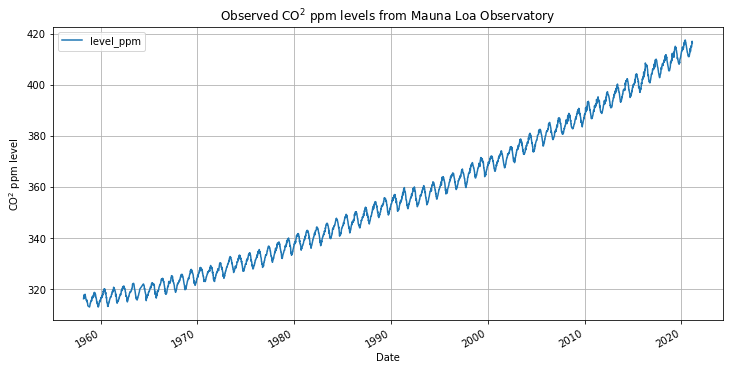

In [5]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)
plt.ylabel('CO$^2$ ppm level')
plt.xlabel('Date')
plt.title('Observed CO$^2$ ppm levels from Mauna Loa Observatory')
plt.savefig('observed_data.png')

In [6]:
df['ordinal'] = df['date'].apply(datetime.toordinal)
df.head()

,date,level_ppm,ordinal
0,1958-03-29,316.25,714867
1,1958-04-05,317.25,714874
2,1958-04-12,317.75,714881
3,1958-04-19,317.50,714888
4,1958-04-26,316.50,714895


In [7]:
last_date = date(2060, 1, 1)
future_dates = pd.date_range(start=max(df['date']),end=last_date).to_series()
future_dates_ordinal = future_dates.apply(datetime.toordinal)
stan_data = {
    'N': len(df),
    'y': df['level_ppm'],
    'x': df['ordinal'],
    'nFutureCount': len(future_dates),
    'futureDays': future_dates_ordinal
}
to_predict_dates = df['date'].append(future_dates)
to_predict = to_predict_dates.apply(datetime.toordinal)

In [8]:
# Generate starting points for the models
lr = LinearRegression(n_jobs=-1)
lr.fit(
    X = df[['ordinal']],
    y = df[['level_ppm']]
)

LinearRegression(n_jobs=-1)

In [9]:
%%time
bad_stan:str = """
data {
    int<lower=1> N;
    vector[N] y;
    vector[N] x;  // Ordinal date
    int<lower=1> nFutureCount;
    vector[nFutureCount] futureDays; // The future days to make predictions for
}

parameters {
    // Linear relationship
    real<lower=-10000, upper=10000>t_intercept;
    real<lower=0, upper=1>t_coef;  // Prior knowledge informs us of increasing c02 levels
    // Seasonal variation
    real<lower=0, upper=5> c2;
    real<lower=-2, upper=2> c3;
    real<lower=0>sigma;  // Standard deviation has to be positive
}

model {
    t_intercept ~ cauchy(-2800, 100);
    t_coef ~ cauchy(0.005, 0.01);
    c2 ~ cauchy(2.5, 1);
    c3 ~ cauchy(0, 1);
    y ~ normal(
        t_intercept + t_coef*x + c2 * cos(2 * pi() * x / 365.25 + c3),
        sigma
    );
}

generated quantities {
   real x_future[nFutureCount];
   for (t in 1:nFutureCount){
       x_future[t] = normal_rng(
           t_intercept + t_coef*(futureDays[t]) + c2 * cos(2 * pi() * (futureDays[t]) / 365.25 + c3),
           sigma
       );
   }
}
"""
bad_stan_model = pystan.StanModel(model_code=bad_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e09ee87c492d075e470a0e6350380faa NOW.


CPU times: user 1.08 s, sys: 77.3 ms, total: 1.16 s
Wall time: 50.5 s


In [17]:
%%time
bad_parameters = ['t_intercept', 't_coef', 'c2', 'c3', 'sigma']
bad_results = bad_stan_model.sampling(
    data=stan_data,
    control = {"max_treedepth": 15},
    init=[{
        't_intercept': lr.intercept_[0],
        't_coef': lr.coef_[0][0]
    }] * 4
)
print(bad_results.stansummary(pars=bad_parameters))
bad_samples = bad_results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_e09ee87c492d075e470a0e6350380faa.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
t_intercept  -2812    0.13   7.86  -2827  -2817  -2812  -2806  -2796   3651    1.0
t_coef      4.4e-3  1.8e-7 1.1e-5 4.3e-3 4.4e-3 4.4e-3 4.4e-3 4.4e-3   3650    1.0
c2            2.83  2.0e-3    0.1   2.63   2.76   2.83    2.9   3.02   2400    1.0
c3           -1.66  7.1e-4   0.04  -1.73  -1.68  -1.66  -1.63  -1.59   2505    1.0
sigma          4.0  9.2e-4   0.05    3.9   3.96    4.0   4.03    4.1   2781    1.0

Samples were drawn using NUTS at Sat Apr 24 07:12:57 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 2.5 s, sys: 3.37 s, total: 5.87 s
Wall time: 19min 58s


In [22]:
%%time
pystan.check_hmc_diagnostics(bad_results)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [18]:
def get_parameter(parameter:str, results, func = np.mean) -> float:
    return np.mean(results[parameter])

In [19]:
# Model parameters
bad_t_intercept = get_parameter('t_intercept', bad_results)
bad_t_coef = get_parameter('t_coef', bad_results)
bad_c2 = get_parameter('c2', bad_results)
bad_c3 = get_parameter('c3', bad_results)

In [20]:
# Stan model future predictions output
bad_prediction = bad_samples['x_future']

# Compute 95% interval of the predicted values
bad_prediction_interval = np.percentile(bad_prediction, axis=0, q=[2.5, 97.5])

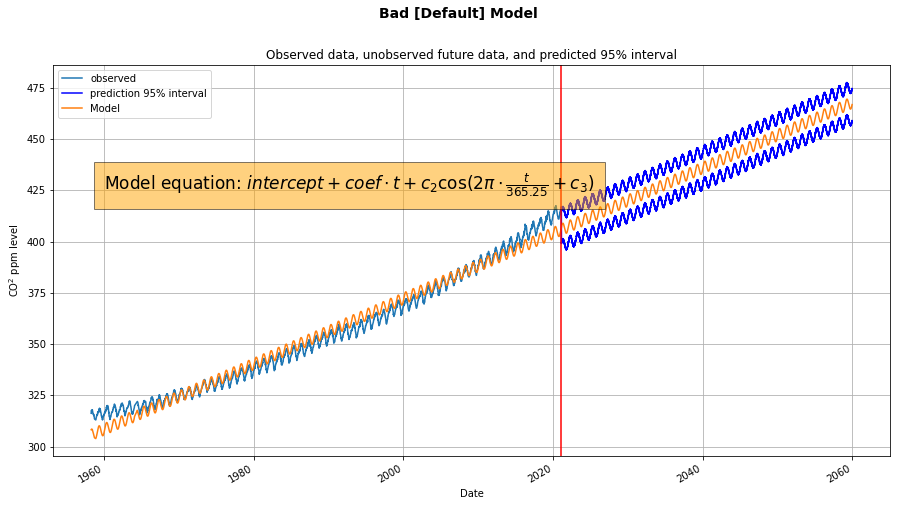

In [21]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Bad [Default] Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = bad_t_intercept + bad_t_coef* to_predict + bad_c2 * np.cos(2 * np.pi * to_predict / 365.25 + bad_c3)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()
ax.set_title('Observed data, unobserved future data, and predicted 95% interval')
ax.text(
    date(1960, 1, 1), 425, 
    r'Model equation: $intercept + coef \cdot t + c_2 \cos(2 \pi \cdot \frac{t}{365.25} + c_3$)', 
    fontsize=17, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10}
)
plt.savefig('bad_model.png')
plt.show()

In [24]:
df['o_2'] = df['ordinal']**2
df['o_3'] = df['ordinal']**3
df['o_4'] = df['ordinal']**4
df.head()

,date,level_ppm,ordinal,o_2,o_3,o_4
0,1958-03-29,316.25,714867,511034827689,365321934165552363,6039259619798853009
1,1958-04-05,317.25,714874,511044835876,365332666002019624,-2178320052055091952
2,1958-04-12,317.75,714881,511054844161,365343398048659841,8051144844164014593
3,1958-04-19,317.50,714888,511064852544,365354130305475072,-165833833078059008
4,1958-04-26,316.50,714895,511074861025,365364862772467375,-8382512004186831935


In [30]:
# Generate starting points for the models
def get_fitted_lr(num: int) -> LinearRegression:
    lr_model = LinearRegression(n_jobs=-1)
    lr_model.fit(
        X = df[['ordinal', f'o_{num}']],
        y = df[['level_ppm']]
    )
    return lr_model

lr_2 = get_fitted_lr(2)
lr_3 = get_fitted_lr(3)
lr_4 = get_fitted_lr(4)

In [27]:
%%time
good_stan: str = """
data {
    int<lower=1> N;
    vector[N] y;
    vector[N] x;  // Ordinal date
    int<lower=1> nFutureCount;
    vector[nFutureCount] futureDays; // The future days to make predictions for
}

parameters {
    // Trend relationship
    real t_intercept;
    real<lower=0, upper=1> a;  // (scaling factor) Cannot be below 0
    real<lower=0, upper=5> b; // Prior knowledge informs us of increasing CO2 levels
    real<lower=1, upper=5> c;
    // Seasonal variation
    real<lower=0, upper=5> c2;
    real<lower=-2, upper=2> c3;
    real<lower=0>sigma;  // Standard deviation has to be positive
}

model {
    t_intercept ~ cauchy(100, 50);
    a ~ cauchy(0,1);
    b ~ cauchy(0,1);
    c ~ cauchy(2, 1);
    c2 ~ cauchy(2.5, 1);
    c3 ~ cauchy(0, 1);
    for (t in 1:N){
        y[t] ~ normal(
            t_intercept + a * x[t] + b * x[t]^c + c2 * cos(2 * pi() * x[t] / 365.25 + c3),
            sigma
        );
    }
}

generated quantities {
   real x_future[nFutureCount];
   for (t in 1:nFutureCount){
    x_future[t] = normal_rng(
        t_intercept + a * futureDays[t] + b * futureDays[t]^c + c2 * cos(2 * pi() * futureDays[t] / 365.25 + c3),
        sigma
    );
   }
}
"""
good_stan_model = pystan.StanModel(model_code=good_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe2bc310b844cb8b11a4eeb79c5ebe04 NOW.


CPU times: user 1.27 s, sys: 189 ms, total: 1.46 s
Wall time: 56.8 s


In [ ]:
%%time
good_parameters = ['t_intercept', 'a', 'b', 'c', 'c2', 'c3', 'sigma']
good_results = good_stan_model.sampling(
    data=stan_data,
    control = {'max_treedepth': 15, 'adapt_delta': 0.9},
    init = [
        {'t_intercept': lr.intercept_[0], 'a': lr.coef_[0][0]},
        {'t_intercept': lr_2.intercept_[0], 'a': lr_2.coef_[0][0], 'b': lr_2.coef_[0][1], 'c': 2},
        {'t_intercept': lr_3.intercept_[0], 'a': lr_3.coef_[0][0], 'b': lr_3.coef_[0][1], 'c': 3},
        {'t_intercept': lr_4.intercept_[0], 'a': lr_4.coef_[0][0], 'b': lr_4.coef_[0][1], 'c': 4}
    ]
)
print(good_results.stansummary(pars=good_parameters))
good_samples = good_results.extract()

In [ ]:
%%time
pystan.check_hmc_diagnostics(good_results)

In [ ]:
# Model parameters
good_t_intercept = get_parameter('t_intercept', good_results)
good_a = get_parameter('a', good_results)
good_b = get_parameter('b', good_results)
good_c = get_parameter('c', good_results)
good_c2 = get_parameter('c2', good_results)
good_c3 = get_parameter('c3', good_results)

In [ ]:
# Stan model future predictions output
good_prediction = good_samples['x_future']

# Compute 95% interval of the predicted values
good_prediction_interval = np.percentile(good_prediction, axis=0, q=[2.5, 97.5])

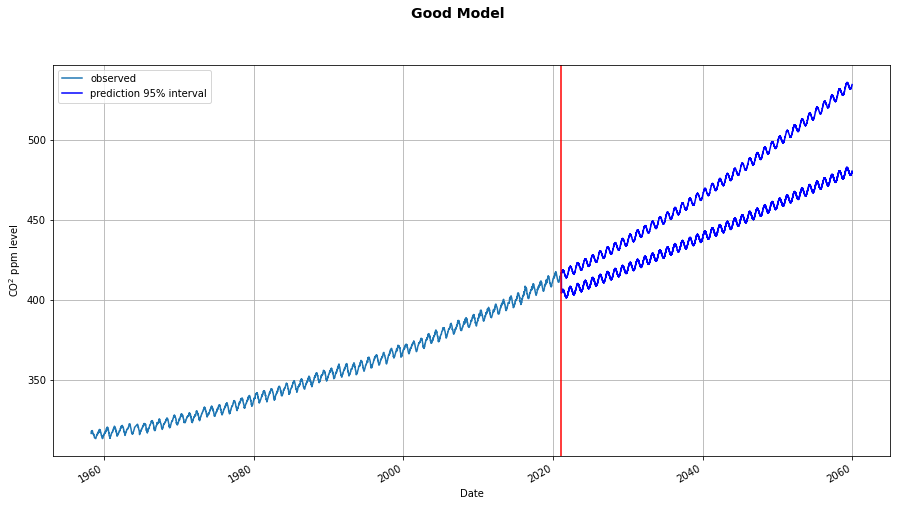

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Good Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = good_c0 + good_c1*np.exp(good_c2 * to_predict*stan_data['scalingFactor']) + good_c3 * np.cos(2 * np.pi * to_predict / 365.25 + good_c4)
# ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()